# Importing the Libraries  

In [1]:
import gym
import numpy as np
import math
from collections import deque
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Q learning Model


1. Initialize the parameters
2. Discretize the states 
3. Action State 
4. Update Q
5. Train the model 
6. Run the model on mountain car


In [2]:
class Q_learning():
    
    def __init__(self,buckets=(12, 12),episodes=400000,epsilon=0.01,discount=0.99,decay=100,force=True):
        self.buckets=buckets
        self.num_episodes=episodes
        self.min_epsilon=epsilon
        self.discount=discount
        self.decay=decay

        self.mc_env=gym.make('MountainCar-v0')
        self.upper_bounds=[self.mc_env.observation_space.high[0], self.mc_env.observation_space.high[1]]
        self.lower_bounds=[self.mc_env.observation_space.low[0], self.mc_env.observation_space.low[1]]
        
        self.Q_table=np.zeros(self.buckets + (self.mc_env.action_space.n,))        
        
        self.learning_rate=0.008
        
        self.threshold=self.mc_env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize(self, obs):
        discretized=list()
        for i in range(len(obs)):
            scaling=(obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_observation=int(round((self.buckets[i] - 1) * scaling))
            new_observation=min(self.buckets[i] - 1, max(0, new_observation))
            discretized.append(new_observation)
        return tuple(discretized)

    
    def action(self, s):
        x = np.random.random()
        if (x < self.epsilon):
            return self.mc_env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[s])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque=deque(maxlen=100)
        scores_array=[]
        average_scores_array = []  
        print_every = 1000
        time_start = time.time()
        
        for i_episode in range(self.num_episodes):
            current_state = self.discretize(self.mc_env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            done = False
            
            epi_reward = 0
            time_step = 0
            
            while not done:
                action = self.action(current_state)
                obs, reward, done, _ = self.mc_env.step(action)   
                new_state = self.discretize(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                epi_reward += reward
                
            scores_deque.append(epi_reward)
            scores_array.append(epi_reward)
            
            average_score = np.mean(scores_deque)
            average_scores_array.append(average_score)
            
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:                
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, epi_reward, average_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if average_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                

        print('Finished training!')
        
        return scores_array, average_scores_array

    def run(self):
        self.mc_env = gym.wrappers.Monitor(self.mc_env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize(self.mc_env.reset())
        while not done:
                self.mc_env.render()
                t = t+1
                action = self.action(current_state)
                obs, reward, done, _ = self.mc_env.step(action)
                new_state = self.discretize(obs)
                current_state = new_state
            
        return t
    
    def close(self):
        self.mc_env.close()

# Training the model on Mountain Cart Environment

In [3]:
def trainer(bucket):
    agent = Q_learning(buckets=(bucket,bucket))
    scores, average_scores = agent.train()
    return agent, scores, average_scores

def value_policy_table(bucket, agent):
    values = np.zeros((bucket,bucket))
    policy = np.zeros((bucket,bucket))
    for i in range(agent.Q_table.shape[0]):
        for j in range(agent.Q_table.shape[1]):
            values[i][j] = max(agent.Q_table[i][j])
            policy[i][j] = np.argmax(agent.Q_table[i][j])
    return values, policy

### Training Agent with 12 Buckets

In [4]:
agent_12_1, scores_12_1, average_scores_12_1 = trainer(12)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:16
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -198.48, eps-greedy:  0.01, Time: 00:00:32
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -192.93, eps-greedy:  0.01, Time: 00:00:46
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -198.57, eps-greedy:  0.01, Time: 00:00:59
Episode: 5000, Timesteps:  161, Score: -161.0,  Avg.Score: -173.16, eps-greedy:  0.01, Time: 00:01:10
Episode: 6000, Timesteps:  157, Score: -157.0,  Avg.Score: -187.65, eps-greedy:  0.01, Time: 00:01:22
Episode: 7000, Timesteps:  175, Score: -175.0,  Avg.Score: -192.37, eps-greedy:  0.01, Time: 00:01:33
Episode: 8000, Timesteps:  200, Score: -200.0,  Avg.Score: -181.27, eps-greedy:  0.01, Time: 00:01:44
Episode: 9000, Timesteps:  187, Score: -187.0,  Avg.Score: -185.40, eps-greedy:  0.01, Time: 00:01:56
Episode: 10000, Timesteps:  162, Score: -162.0,  Avg.Score: -17

In [5]:
agent_12_2, scores_12_2, average_scores_12_2 = trainer(12)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -195.31, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  172, Score: -172.0,  Avg.Score: -195.99, eps-greedy:  0.01, Time: 00:00:34
Episode: 4000, Timesteps:  166, Score: -166.0,  Avg.Score: -174.37, eps-greedy:  0.01, Time: 00:00:45
Episode: 5000, Timesteps:  188, Score: -188.0,  Avg.Score: -195.71, eps-greedy:  0.01, Time: 00:00:56
Episode: 6000, Timesteps:  200, Score: -200.0,  Avg.Score: -176.87, eps-greedy:  0.01, Time: 00:01:07
Episode: 7000, Timesteps:  200, Score: -200.0,  Avg.Score: -183.28, eps-greedy:  0.01, Time: 00:01:17
Episode: 8000, Timesteps:  167, Score: -167.0,  Avg.Score: -186.16, eps-greedy:  0.01, Time: 00:01:28
Episode: 9000, Timesteps:  200, Score: -200.0,  Avg.Score: -176.73, eps-greedy:  0.01, Time: 00:01:39
Episode: 10000, Timesteps:  188, Score: -188.0,  Avg.Score: -17

In [6]:
agent_12_3, scores_12_3, average_scores_12_3 = trainer(12)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  194, Score: -194.0,  Avg.Score: -196.63, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -195.48, eps-greedy:  0.01, Time: 00:00:34
Episode: 4000, Timesteps:  175, Score: -175.0,  Avg.Score: -192.93, eps-greedy:  0.01, Time: 00:00:45
Episode: 5000, Timesteps:  157, Score: -157.0,  Avg.Score: -193.18, eps-greedy:  0.01, Time: 00:00:56
Episode: 6000, Timesteps:  172, Score: -172.0,  Avg.Score: -195.97, eps-greedy:  0.01, Time: 00:01:07
Episode: 7000, Timesteps:  200, Score: -200.0,  Avg.Score: -170.65, eps-greedy:  0.01, Time: 00:01:18
Episode: 8000, Timesteps:  194, Score: -194.0,  Avg.Score: -180.83, eps-greedy:  0.01, Time: 00:01:28
Episode: 9000, Timesteps:  194, Score: -194.0,  Avg.Score: -168.46, eps-greedy:  0.01, Time: 00:01:38
Episode: 10000, Timesteps:  200, Score: -200.0,  Avg.Score: -16

In [7]:
values_12_1, policy_12_1 = value_policy_table(12, agent_12_1)
values_12_2, policy_12_2 = value_policy_table(12, agent_12_2)
values_12_3, policy_12_3 = value_policy_table(12, agent_12_3)

In [8]:
policy_12_1

array([[0., 0., 0., 1., 0., 1., 2., 2., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 2., 2., 2., 2., 2., 0., 0.],
       [1., 2., 0., 0., 2., 2., 2., 2., 2., 2., 0., 0.],
       [0., 1., 0., 0., 1., 1., 2., 2., 2., 2., 1., 0.],
       [2., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 0.],
       [2., 0., 1., 0., 0., 0., 1., 2., 2., 2., 2., 0.],
       [0., 1., 1., 0., 0., 0., 0., 2., 2., 0., 2., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 2., 2., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0.],
       [0., 0., 0., 2., 0., 0., 0., 2., 2., 0., 2., 0.],
       [0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
policy_12_2

array([[0., 1., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0.],
       [2., 1., 1., 2., 2., 2., 2., 2., 2., 0., 0., 0.],
       [2., 0., 0., 0., 1., 1., 2., 2., 2., 2., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 2., 0.],
       [2., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 0.],
       [1., 0., 0., 0., 0., 0., 0., 2., 1., 2., 2., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
policy_12_3

array([[0., 2., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0.],
       [1., 2., 1., 0., 2., 2., 2., 2., 2., 1., 0., 0.],
       [1., 2., 1., 0., 2., 2., 2., 2., 2., 2., 0., 0.],
       [2., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 0.],
       [0., 0., 0., 0., 2., 0., 2., 2., 1., 2., 2., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 0.],
       [2., 1., 0., 2., 0., 0., 0., 0., 2., 0., 2., 0.],
       [0., 1., 2., 0., 0., 0., 0., 0., 2., 2., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 2., 2., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 2., 2., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Plotting the heatmaps for 12 buckets

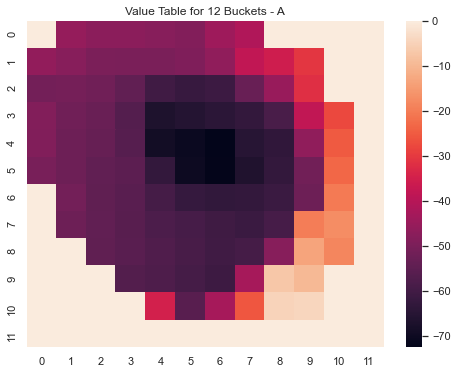

In [11]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_12_1, ax = ax)
ax.set_title('Value Table for 12 Buckets - A')
plt.show()

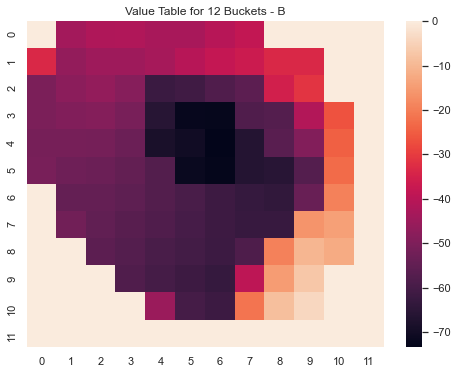

In [12]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_12_2, ax = ax)
ax.set_title('Value Table for 12 Buckets - B')
plt.show()

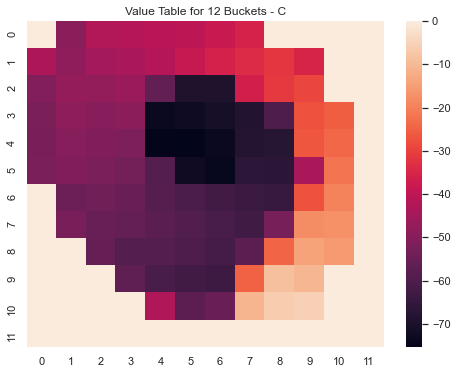

In [13]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_12_3, ax = ax)
ax.set_title('Value Table for 12 Buckets - C')
plt.show()

### Training Agent with 16 Buckets

In [14]:
agent_16_1, scores_16_1, average_scores_16_1 = trainer(16)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:35
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -198.67, eps-greedy:  0.01, Time: 00:00:46
Episode: 5000, Timesteps:  200, Score: -200.0,  Avg.Score: -198.84, eps-greedy:  0.01, Time: 00:00:58
Episode: 6000, Timesteps:  200, Score: -200.0,  Avg.Score: -198.86, eps-greedy:  0.01, Time: 00:01:09
Episode: 7000, Timesteps:  200, Score: -200.0,  Avg.Score: -196.38, eps-greedy:  0.01, Time: 00:01:20
Episode: 8000, Timesteps:  125, Score: -125.0,  Avg.Score: -160.08, eps-greedy:  0.01, Time: 00:01:31
Episode: 9000, Timesteps:  200, Score: -200.0,  Avg.Score: -184.51, eps-greedy:  0.01, Time: 00:01:42
Episode: 10000, Timesteps:  147, Score: -147.0,  Avg.Score: -17

In [15]:
agent_16_2, scores_16_2, average_scores_16_2 = trainer(16)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:34
Episode: 4000, Timesteps:  163, Score: -163.0,  Avg.Score: -196.16, eps-greedy:  0.01, Time: 00:00:46
Episode: 5000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.79, eps-greedy:  0.01, Time: 00:00:57
Episode: 6000, Timesteps:  200, Score: -200.0,  Avg.Score: -193.11, eps-greedy:  0.01, Time: 00:01:09
Episode: 7000, Timesteps:  200, Score: -200.0,  Avg.Score: -198.59, eps-greedy:  0.01, Time: 00:01:20
Episode: 8000, Timesteps:  188, Score: -188.0,  Avg.Score: -182.32, eps-greedy:  0.01, Time: 00:01:31
Episode: 9000, Timesteps:  189, Score: -189.0,  Avg.Score: -180.39, eps-greedy:  0.01, Time: 00:01:42
Episode: 10000, Timesteps:  200, Score: -200.0,  Avg.Score: -18

In [16]:
agent_16_3, scores_16_3, average_scores_16_3 = trainer(16)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:34
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.04, eps-greedy:  0.01, Time: 00:00:46
Episode: 5000, Timesteps:  181, Score: -181.0,  Avg.Score: -195.76, eps-greedy:  0.01, Time: 00:00:57
Episode: 6000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.94, eps-greedy:  0.01, Time: 00:01:09
Episode: 7000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.95, eps-greedy:  0.01, Time: 00:01:20
Episode: 8000, Timesteps:  149, Score: -149.0,  Avg.Score: -163.04, eps-greedy:  0.01, Time: 00:01:31
Episode: 9000, Timesteps:  200, Score: -200.0,  Avg.Score: -177.58, eps-greedy:  0.01, Time: 00:01:42
Episode: 10000, Timesteps:  200, Score: -200.0,  Avg.Score: -17

In [17]:
values_16_1, policy_16_1 = value_policy_table(16, agent_16_1)
values_16_2, policy_16_2 = value_policy_table(16, agent_16_2)
values_16_3, policy_16_3 = value_policy_table(16, agent_16_3)

In [18]:
policy_16_1

array([[0., 0., 2., 1., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 2., 0., 2., 2., 2., 2., 2., 2., 1., 0., 0., 0., 0.],
       [2., 1., 0., 1., 2., 0., 0., 2., 2., 1., 2., 2., 2., 0., 0., 0.],
       [2., 0., 2., 0., 0., 2., 0., 2., 0., 2., 2., 2., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 0., 0.],
       [2., 0., 0., 2., 0., 0., 0., 2., 2., 1., 2., 2., 2., 2., 2., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 0.],
       [1., 1., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 2., 2., 2., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 2., 2., 0.],
       [0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 2., 1., 2., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 2., 1., 0., 0., 2., 1.,

In [19]:
policy_16_2

array([[0., 0., 2., 0., 1., 0., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0.],
       [2., 0., 1., 0., 1., 0., 0., 0., 1., 1., 2., 1., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 2., 2., 2., 0., 0.],
       [0., 2., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 1., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 2., 2., 2., 1., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 2., 2., 0., 2., 2., 2., 2., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 2., 2., 2., 2., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 2., 2., 2., 0.],
       [0., 2., 1., 0., 0., 0., 1., 0., 0., 1., 2., 2., 2., 2., 2., 0.],
       [0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 1., 0.],
       [0., 0., 0., 2., 0., 2., 2., 2., 1., 0., 2., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 1., 2., 2., 0., 2., 2., 2., 2., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.,

In [20]:
policy_16_3

array([[0., 2., 1., 0., 1., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 2., 2., 2., 0., 2., 0., 1., 2., 2., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0., 2., 2., 0., 0., 0.],
       [2., 0., 0., 1., 1., 0., 0., 1., 2., 2., 2., 2., 2., 2., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 2., 2., 2., 2., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 2., 2., 2., 0.],
       [0., 2., 2., 0., 0., 0., 2., 2., 1., 1., 2., 2., 2., 0., 2., 0.],
       [0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 2., 2., 2., 2., 2., 0.],
       [0., 0., 2., 1., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1., 2., 1., 2., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 2., 2., 2., 0.,

### Plotting the heatmaps for 16 buckets

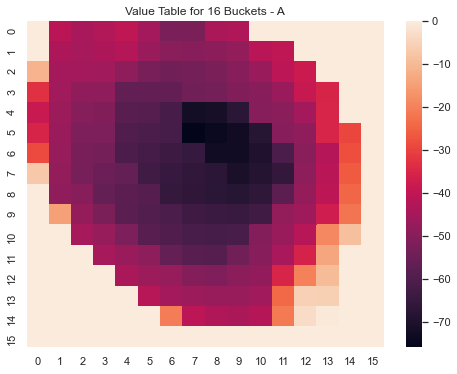

In [21]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_16_1, ax = ax)
ax.set_title('Value Table for 16 Buckets - A')
plt.show()

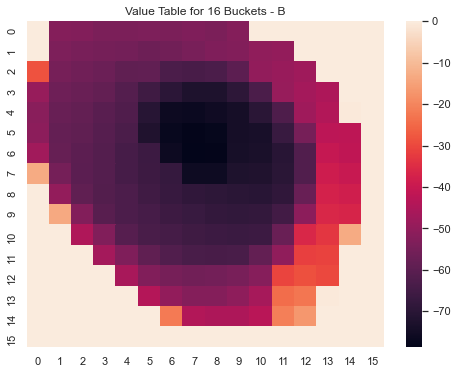

In [22]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_16_2, ax = ax)
ax.set_title('Value Table for 16 Buckets - B')
plt.show()

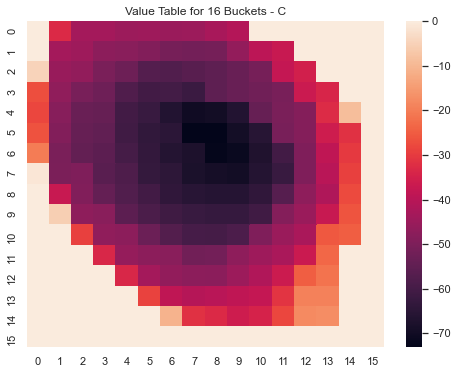

In [23]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_16_3, ax = ax)
ax.set_title('Value Table for 16 Buckets - C')
plt.show()

### 20 Buckets

In [24]:
agent_20_1, scores_20_1, average_scores_20_1 = trainer(20)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:34
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:46
Episode: 5000, Timesteps:  200, Score: -200.0,  Avg.Score: -198.60, eps-greedy:  0.01, Time: 00:00:58
Episode: 6000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.87, eps-greedy:  0.01, Time: 00:01:09
Episode: 7000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:01:21
Episode: 8000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:01:32
Episode: 9000, Timesteps:  200, Score: -200.0,  Avg.Score: -189.15, eps-greedy:  0.01, Time: 00:01:44
Episode: 10000, Timesteps:  179, Score: -179.0,  Avg.Score: -19

In [25]:
agent_20_2, scores_20_2, average_scores_20_2 = trainer(20)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:34
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.77, eps-greedy:  0.01, Time: 00:00:46
Episode: 5000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.85, eps-greedy:  0.01, Time: 00:00:58
Episode: 6000, Timesteps:  200, Score: -200.0,  Avg.Score: -197.61, eps-greedy:  0.01, Time: 00:01:09
Episode: 7000, Timesteps:  200, Score: -200.0,  Avg.Score: -199.13, eps-greedy:  0.01, Time: 00:01:21
Episode: 8000, Timesteps:  200, Score: -200.0,  Avg.Score: -177.49, eps-greedy:  0.01, Time: 00:01:32
Episode: 9000, Timesteps:  200, Score: -200.0,  Avg.Score: -197.93, eps-greedy:  0.01, Time: 00:01:44
Episode: 10000, Timesteps:  200, Score: -200.0,  Avg.Score: -19

In [26]:
agent_20_3, scores_20_3, average_scores_20_3 = trainer(20)

threshold:  -110.0
Episode: 1000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:11
Episode: 2000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:23
Episode: 3000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:34
Episode: 4000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:00:46
Episode: 5000, Timesteps:  176, Score: -176.0,  Avg.Score: -198.98, eps-greedy:  0.01, Time: 00:00:58
Episode: 6000, Timesteps:  200, Score: -200.0,  Avg.Score: -197.92, eps-greedy:  0.01, Time: 00:01:09
Episode: 7000, Timesteps:  165, Score: -165.0,  Avg.Score: -186.06, eps-greedy:  0.01, Time: 00:01:21
Episode: 8000, Timesteps:  200, Score: -200.0,  Avg.Score: -200.00, eps-greedy:  0.01, Time: 00:01:32
Episode: 9000, Timesteps:  173, Score: -173.0,  Avg.Score: -193.71, eps-greedy:  0.01, Time: 00:01:44
Episode: 10000, Timesteps:  199, Score: -199.0,  Avg.Score: -18

In [27]:
values_20_1, policy_20_1 = value_policy_table(20, agent_20_1)
values_20_2, policy_20_2 = value_policy_table(20, agent_20_2)
values_20_3, policy_20_3 = value_policy_table(20, agent_20_3)

In [28]:
policy_20_1

array([[0., 1., 1., 1., 2., 1., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 2., 0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 0., 0.,
        0., 0., 0., 0.],
       [0., 2., 0., 2., 2., 0., 0., 2., 1., 0., 0., 0., 2., 2., 2., 0.,
        0., 0., 0., 0.],
       [1., 2., 0., 1., 2., 1., 0., 1., 1., 1., 2., 2., 2., 0., 2., 2.,
        2., 0., 0., 0.],
       [0., 1., 1., 1., 0., 2., 0., 1., 2., 2., 2., 2., 2., 2., 0., 1.,
        2., 1., 0., 0.],
       [0., 0., 0., 1., 0., 2., 0., 0., 2., 2., 2., 2., 2., 2., 2., 0.,
        2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 2.,
        1., 2., 2., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2.,
        2., 2., 1., 0.],
       [1., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 2., 2., 2., 2., 2.,
        1., 2., 2., 0.],
       [0., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2., 2., 2.,
        1., 2., 2., 0.],
       [0., 1., 0., 0., 0., 0.

In [29]:
policy_20_2

array([[0., 2., 0., 2., 0., 0., 1., 0., 1., 2., 2., 2., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 2., 0., 2., 0., 1., 1., 1., 2., 0., 2., 2., 2., 2., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 0.,
        0., 0., 0., 0.],
       [1., 2., 0., 0., 0., 1., 0., 2., 1., 2., 0., 2., 2., 2., 2., 2.,
        1., 0., 0., 0.],
       [1., 0., 2., 0., 0., 0., 0., 1., 2., 0., 2., 0., 0., 2., 2., 2.,
        2., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 2., 2., 2., 1., 0., 1.,
        2., 2., 0., 0.],
       [1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2.,
        2., 2., 1., 0.],
       [1., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 2., 1., 1.,
        2., 2., 2., 0.],
       [2., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.,
        2., 2., 2., 0.],
       [2., 2., 2., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 2., 2., 2.,
        2., 2., 2., 0.],
       [0., 2., 0., 1., 0., 0.

In [30]:
policy_20_3

array([[0., 0., 2., 2., 0., 2., 1., 0., 0., 0., 2., 2., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 2., 1., 2., 2., 1., 2., 2., 2., 2., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 2., 2., 1., 2., 2., 2., 2., 2., 0., 2., 0.,
        0., 0., 0., 0.],
       [2., 0., 0., 2., 1., 0., 0., 0., 2., 1., 2., 2., 2., 2., 2., 2.,
        1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 2., 1., 2., 2., 2., 2.,
        2., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 0., 0.],
       [0., 2., 2., 0., 1., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2.,
        2., 1., 1., 0.],
       [0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2., 2., 1., 2., 1., 2.,
        1., 2., 2., 0.],
       [1., 0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 1., 2., 2., 1., 2.,
        2., 2., 2., 0.],
       [0., 2., 0., 0., 1., 0.

### Plotting the heatmaps for 20 buckets

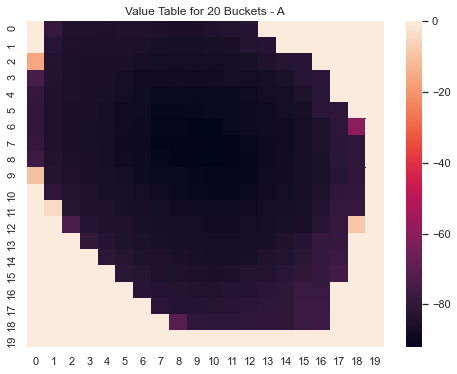

In [31]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_20_1, ax = ax)
ax.set_title('Value Table for 20 Buckets - A')
plt.show()

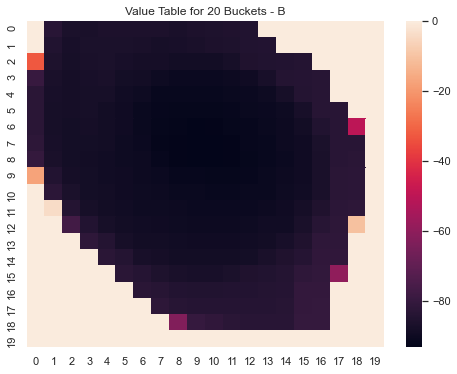

In [32]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_20_2, ax = ax)
ax.set_title('Value Table for 20 Buckets - B')
plt.show()

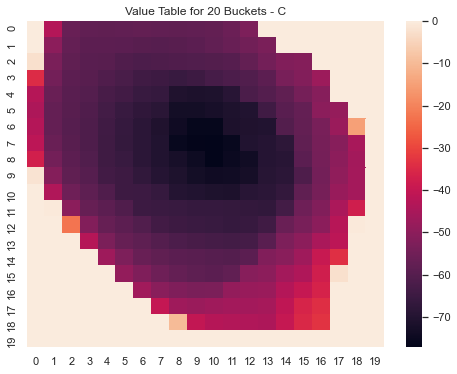

In [33]:
sns.set(rc={'figure.figsize':(8,6)})
ax = plt.axes()
sns.heatmap(values_20_3, ax = ax)
ax.set_title('Value Table for 20 Buckets - C')
plt.show()

# Plotting the graphs (Average score V/S Episode number)

### 12 buckets

length of scores:  400000 , len of average_scores:  400000


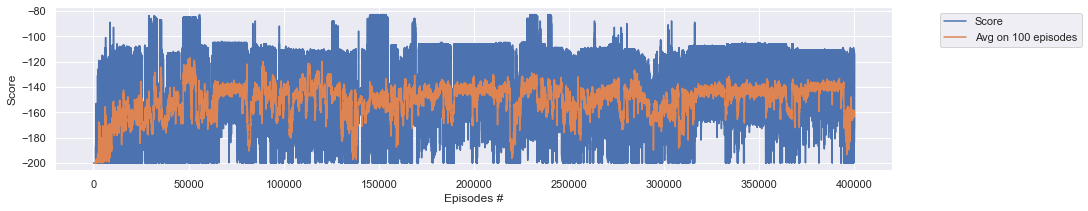

In [34]:
%matplotlib inline

print('length of scores: ', len(scores_12_1), ', len of average_scores: ', len(average_scores_12_1))

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_12_1)+1), scores_12_1, label="Score")
plt.plot(np.arange(1, len(average_scores_12_1)+1), average_scores_12_1, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

### 16 buckets

length of scores:  58581 , len of average_scores:  58581


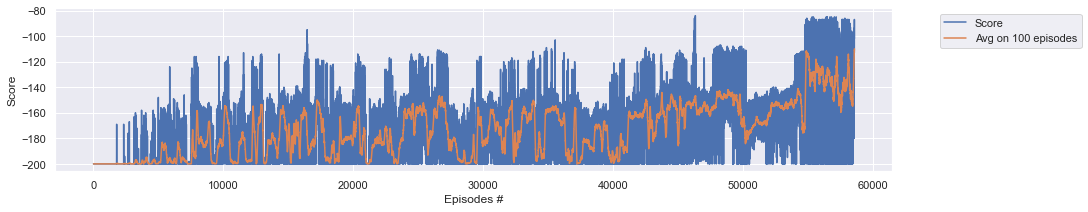

In [35]:
%matplotlib inline

print('length of scores: ', len(scores_16_1), ', len of average_scores: ', len(average_scores_16_1))

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_16_1)+1), scores_16_1, label="Score")
plt.plot(np.arange(1, len(average_scores_16_1)+1), average_scores_16_1, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

### 20 buckets

length of scores:  400000 , len of average_scores:  400000


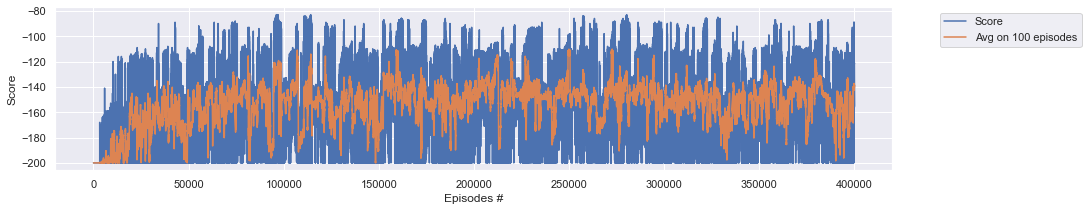

In [36]:
%matplotlib inline

print('length of scores: ', len(scores_20_1), ', len of average_scores: ', len(average_scores_20_1))

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_20_1)+1), scores_20_1, label="Score")
plt.plot(np.arange(1, len(average_scores_20_1)+1), average_scores_20_1, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()